## Traditional ML classification models under wavelet analysis structures

In [1]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pandas as pd
import sklearn
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

### Implementations
#### Configurations

In [2]:
# Configurations - Feature names
LOWLUX = 'lowlux'
MIDLUX = 'middlelux'
HIGHLUX = 'highlux'
NOBACK = 'nothing'
ONEBACK = 'ONEBACK'
TWOBACK = 'TWOBACK'
THREEBACK = 'THREEBACK'
FILENAME = 'Filename'
IPA2 = 'IPA 2'
INDEX = 'index'
LUX = 'Luminance'
LABELS = 'Labels'
ISBLINK_LEFT = 'isBlink-Left'
ISBLINK_RIGHT = 'isBlink-Right'
PID = 'PID'
AVE_DM = 'Averaged Diameter'
DIFF_DM = 'Difference Diameter'

IPA_LEFT = 'IPA Left'
IPA_RIGHT = 'IPA Right'

LHIPA_LEFT = 'LHIPA Left'
LHIPA_RIGHT = 'LHIPA Right'

# Model names.
KNN = 'KNN'
SVM = 'SVM'
RF = 'Random Forest'

# Training and testing ratio.
TEST_SIZE_PCT = 0.2

# Hyper-parameters tuning.
# Setting thresholds for 2 eyes' blinking rates.
THRES_BLINKING_RATE = 1.00 # The default value.
# The random forest layers.
RF_DEPTH = 15

#### Read data

In [3]:
# Read data and make them into processable formalities.
# filepath = '../Data/Results/21-11-13-13/results.csv' # Without ipa and lhipa features.
# filepath = '../Data/Results/22-11-22-23/results.csv' # With ipa and lhipa features. Sliding window: 5:3.
# filepath = '../Data/Results/23-11-09-08/results.csv' # With ipa and lhipa features. Sliding window: 5:4.
# filepath = '../Data/Results/23-11-09-51/results.csv' # With ipa and lhipa features. Sliding window: 2:1.6
# filepath = '../Data/Results/23-11-12-48/results.csv' # With ipa and lhipa features. Sliding window: 8-7
# filepath = '../Data/Results/23-11-14-06/results.csv' # With ipa and lhipa features. Sliding window: 10-8 
filepath = '../Data/Results/23-11-14-24/results.csv' # With ipa and lhipa features. Sliding window: 10-9.5 --> # The longer the window, the more data, the better.

df_raw_features = pd.read_csv(filepath)

In [4]:
df_raw_features

,Left-0,Left-1,Left-2,Left-3,Left-4,Left-5,Left-6,Left-7,Left-8,Left-9,...,IPA Right,LHIPA Left,LHIPA Right,Averaged Diameter,Difference Diameter,isBlink-Left,isBlink-Right,Luminance,PID,Labels
0,91.034258,89.989285,89.446541,90.484821,90.426471,90.335952,90.534715,90.501256,90.304912,90.299277,...,0.3,8.7,9.2,46.345515,-2.967561,0.181667,0.204167,lowlux,7,nothing
1,89.189282,90.032590,90.520370,90.535173,89.393462,89.260975,89.723475,89.739829,89.843400,89.386548,...,0.3,8.4,8.8,46.310302,-2.970814,0.230000,0.254167,lowlux,7,nothing
2,89.405825,90.062178,89.889318,90.441738,90.071239,89.969749,89.973210,89.938218,89.923749,89.902937,...,0.3,8.4,8.8,46.262647,-2.944221,0.230000,0.282500,lowlux,7,nothing
3,89.058885,89.907091,89.644695,89.760700,89.699774,89.692021,89.670517,89.651260,89.632876,89.609174,...,0.3,8.8,8.9,46.196961,-2.897179,0.195833,0.249167,lowlux,7,nothing
4,89.923877,90.984776,90.424379,90.550879,90.366908,90.284532,90.175600,90.071465,89.966849,89.862239,...,0.2,8.8,8.8,46.140701,-2.861161,0.151667,0.199167,lowlux,7,nothing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10685,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,0.5,0.0,6.9,46.141200,0.966951,1.000000,0.642500,lowlux,2,THREEBACK
10686,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,0.6,0.0,7.1,46.121692,1.005967,1.000000,0.592500,lowlux,2,THREEBACK
10687,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,0.5,0.0,7.1,46.103429,1.042494,1.000000,0.572500,lowlux,2,THREEBACK
10688,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,0.5,0.0,7.2,46.075288,1.098775,1.000000,0.598333,lowlux,2,THREEBACK


#### Encoder

This part encodes features into numeric values.

In [5]:
# Encoding and Labeling
luxes = []
nbacks = []
df_numeric_features = df_raw_features.copy()

for index, row in df_numeric_features.iterrows():
    # Label luxes
    if LOWLUX in row[LUX]:
        luxes.append(1)
    elif MIDLUX in row[LUX]:
        luxes.append(2)
    elif HIGHLUX in row[LUX]:
        luxes.append(3)
    
    # Label task difficulties
    if NOBACK in row[LABELS]:
        nbacks.append(0)
    elif ONEBACK in row[LABELS]:
        nbacks.append(1)
    elif TWOBACK in row[LABELS]:
        nbacks.append(2)
    elif THREEBACK in row[LABELS]:
        nbacks.append(3)
        
df_numeric_features[LUX] = luxes
df_numeric_features[LABELS] = nbacks

In [6]:
df_numeric_features

,Left-0,Left-1,Left-2,Left-3,Left-4,Left-5,Left-6,Left-7,Left-8,Left-9,...,IPA Right,LHIPA Left,LHIPA Right,Averaged Diameter,Difference Diameter,isBlink-Left,isBlink-Right,Luminance,PID,Labels
0,91.034258,89.989285,89.446541,90.484821,90.426471,90.335952,90.534715,90.501256,90.304912,90.299277,...,0.3,8.7,9.2,46.345515,-2.967561,0.181667,0.204167,1,7,0
1,89.189282,90.032590,90.520370,90.535173,89.393462,89.260975,89.723475,89.739829,89.843400,89.386548,...,0.3,8.4,8.8,46.310302,-2.970814,0.230000,0.254167,1,7,0
2,89.405825,90.062178,89.889318,90.441738,90.071239,89.969749,89.973210,89.938218,89.923749,89.902937,...,0.3,8.4,8.8,46.262647,-2.944221,0.230000,0.282500,1,7,0
3,89.058885,89.907091,89.644695,89.760700,89.699774,89.692021,89.670517,89.651260,89.632876,89.609174,...,0.3,8.8,8.9,46.196961,-2.897179,0.195833,0.249167,1,7,0
4,89.923877,90.984776,90.424379,90.550879,90.366908,90.284532,90.175600,90.071465,89.966849,89.862239,...,0.2,8.8,8.8,46.140701,-2.861161,0.151667,0.199167,1,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10685,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,0.5,0.0,6.9,46.141200,0.966951,1.000000,0.642500,1,2,3
10686,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,0.6,0.0,7.1,46.121692,1.005967,1.000000,0.592500,1,2,3
10687,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,0.5,0.0,7.1,46.103429,1.042494,1.000000,0.572500,1,2,3
10688,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,0.5,0.0,7.2,46.075288,1.098775,1.000000,0.598333,1,2,3


#### Data visualization

In [7]:
# sns.pairplot(df_labels_IPA2, hue=LABELS)

#### Auxiliary functions

In [8]:
# Show machine learning models' performance.
def show_performance(y_true, y_pred, model_name):
    # Get the accuracy score.
    acc_score = accuracy_score(y_true, y_pred)
    
    # Get the F1 score.
    # I chose the macro for worrying about the imbanlance of labels. In my case, since I don't filter instances bsed on blinking rates, I use micro.
    # Ref: https://datascience.stackexchange.com/questions/40900/whats-the-difference-between-sklearn-f1-score-micro-and-weighted-for-a-mult. The 'micro' uses the global number of TP, FN, FP and calculates the F1 directly without favouring any classes.
    f1_score = sklearn.metrics.f1_score(y_true, y_pred, average='macro')  # Before resetting the 0-back time equals to the 1,2,3-backs, I use the macro.
    
    # Get the confusion matrices and display them.
    cm = confusion_matrix(y_true, y_pred)
    cm_display = ConfusionMatrixDisplay(cm)
    
    # Plot the confusion matrix.
    ax = plt.figure().subplots()
    ax.set(title=model_name + " MODEL")
    
    cm_display.plot(ax=ax)
    plt.show()
    
    return acc_score, f1_score

In [9]:
# Plot class distributions with a bar chart.
# Learnt from the quora here.https://stackoverflow.com/questions/63650646/add-labels-and-title-to-a-plot-made-using-pandas.
def plot_class_distribution(df_input, title, x_label, y_label, class_column):
    df = df_input.copy()
    ax = pd.Series(df[class_column]).value_counts().sort_index()
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    ax.plot(kind='bar')
    plt.show()
    return None

#### Clean the instances and features

In [10]:
# Select validated rows/instances by thresholdings.
def validate_instances(df_input):
    df = df_input.copy()
    
    # Plot the original class distributions.
    plot_class_distribution(df_input=df, title='Original instances - class distribution', x_label='Classes', y_label='Instances', class_column=LABELS) # class distributions before.
    
    # Remove instances with high blinking rates.
    before_blinking_filter = len(df)
    df = df.loc[df[ISBLINK_LEFT] <= THRES_BLINKING_RATE]
    df = df.loc[df[ISBLINK_RIGHT] <= THRES_BLINKING_RATE]
    after_blinking_filter = len(df)
    lost_data_num = before_blinking_filter - after_blinking_filter
    print('The blinking threshold is: ' + str(THRES_BLINKING_RATE) + '. Before there was: ' + str(before_blinking_filter) + ' instances, then there is : ' + str(after_blinking_filter) + ' instances. ' + str(lost_data_num) + ' instances are lost.')
    plot_class_distribution(df_input=df, title='Tuned instances - class distribution', x_label='Classes', y_label='Instances', class_column=LABELS) # Show the class distributions after tuning.
    
#     # Try with less classes.
#     df = df.loc[df[LABELS] < 3] # Try with 3 labels: 0, 1, 2 since LHIPA was not sensitive to the THREEBACKs.
#     df = df.loc[df[LABELS] != 1] # Try with 3 labels: 0, 2 since LHIPA was not sensitive to these 2 classes. dfObj[(dfObj['Sale'] > 30) & (dfObj['Sale'] < 33) ]
    
    # Reset the index.
    df = df.reset_index()
    df = df.loc[:, df.columns != 'index']
    
    # Get the output.
    df_output = df.copy()
    return df_output

In [11]:
def select_features(df_input, selected_feature_sets, dropped_feature_sets):
    df = df_input.copy()
    
    # Feature selection
    # Remove PID label / feature.
    df = df.loc[:, df.columns != PID]
#     
#     # Remove lux
#     df = df.loc[:, df.columns != LUX]
#     
#     # Remove the blinking rates related features.
#     df = df.loc[:, df.columns != ISBLINK_LEFT]
#     df = df.loc[:, df.columns != ISBLINK_RIGHT]
    
    # Select features according to needs.
    if dropped_feature_sets is False and selected_feature_sets is not False:
        selected_feature_sets.append(ISBLINK_LEFT)
        selected_feature_sets.append(ISBLINK_RIGHT)
        selected_feature_sets.append(LUX)
#         selected_feature_sets.append(PID)
        
        selected_feature_sets.append(LABELS)
        df_output = df[selected_feature_sets]
    elif selected_feature_sets is False and dropped_feature_sets is not False:
        for feature in dropped_feature_sets:
            df = df.loc[:, df.columns != feature]
        df_output = df.copy()
    elif dropped_feature_sets is False and selected_feature_sets is False:
        df_output = df.copy()
    
    return df_output

#### Run the models

In [12]:
# Run the models, get the results.
def train_test_models(df_input, label_string):
    df = df_input.copy()
    
    # Split dataset.
    # Get the X and y sets.
    X = df.loc[:, df.columns != LABELS].to_numpy()
    y = df.loc[:, df.columns == LABELS].to_numpy()
    y = np.reshape(y, -1)
    
    # Split the data into training dataset and validation dataset.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE_PCT, random_state=999)
    
    # Train with models.
    print('------------------------------------------------' + label_string + ' Model ------------------------------------------------')
    
#     # SVM model. TODO: try the SVM model mentioned in 2022 ISMAR and boosting method, and also feature selection method.
#     clf_svm = make_pipeline(StandardScaler(),SVC(kernel='poly', degree=7)) #SVC(kernel='rbf', gamma='auto'))
#     # Try SVM, bacause it is one of the most widely used models in cognitive workload claissfications.
#     clf_svm.fit(X_train, y_train)
#     y_pred_svm = clf_svm.predict(X_test)
#     score_svm = show_performance(y_true=y_test, y_pred=y_pred_svm, model_name = SVM)
    score_svm = 0
    
    # KNN model.
    clf_knn = KNeighborsClassifier(n_neighbors=5)
    # Train the model.
    clf_knn.fit(X_train, y_train)
    # Test.
    y_pred_knn = clf_knn.predict(X_test)
    acc_score_knn, f1_score_knn = show_performance(y_true=y_test, y_pred=y_pred_knn, model_name = KNN)
    
    # Random Forest model.
    clf_rf = RandomForestClassifier(max_depth=RF_DEPTH, random_state=0)
    # Train the model.
    clf_rf.fit(X_train, y_train)
    # Test.
    y_pred_rf = clf_rf.predict(X_test)
    acc_score_rf, f1_score_rf = show_performance(y_true=y_test, y_pred=y_pred_rf, model_name = RF)
    
    # Print the results.
    print('\nThe KNN accuracy is: ' + str(acc_score_knn) +  '\nThe RF accuracy is: ' + str(acc_score_rf))
    print('\nThe KNN F1 is: ' + str(f1_score_knn) +  '\nThe RF F1 is: ' + str(f1_score_rf))
    print('\nThe used features are: ') # Briefly display the features utilized.
    print(df)
    
    # Output the data.
    df_output = df.copy()
    return df_output

#### Machine Learning Implementations

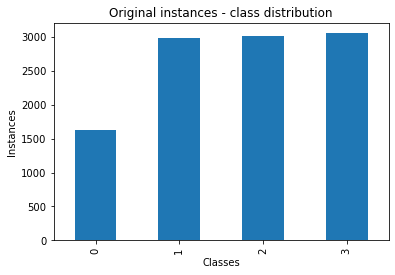

The blinking threshold is: 1.0. Before there was: 10690 instances, then there is : 10690 instances. 0 instances are lost.


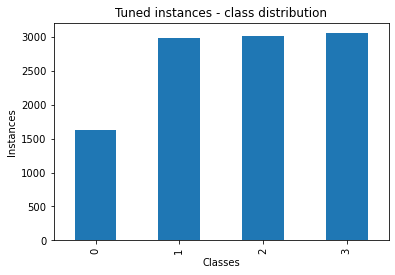

------------------------------------------------Time-domain-based Features Model ------------------------------------------------


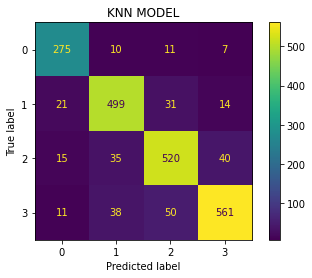

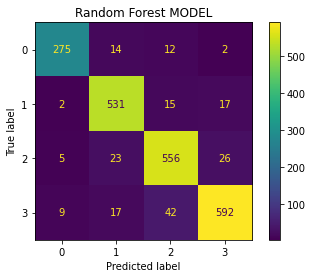


The KNN accuracy is: 0.8676333021515436
The RF accuracy is: 0.9139382600561272

The KNN F1 is: 0.8690886849853783
The RF F1 is: 0.9156712281203406

The used features are: 
       Averaged Diameter  Difference Diameter  isBlink-Left  isBlink-Right  \
0              46.345515            -2.967561      0.181667       0.204167   
1              46.310302            -2.970814      0.230000       0.254167   
2              46.262647            -2.944221      0.230000       0.282500   
3              46.196961            -2.897179      0.195833       0.249167   
4              46.140701            -2.861161      0.151667       0.199167   
...                  ...                  ...           ...            ...   
10685          46.141200             0.966951      1.000000       0.642500   
10686          46.121692             1.005967      1.000000       0.592500   
10687          46.103429             1.042494      1.000000       0.572500   
10688          46.075288             1.098775  

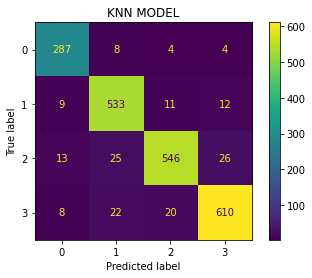

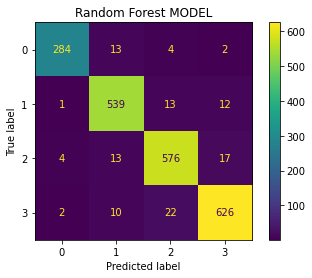


The KNN accuracy is: 0.9242282507015903
The RF accuracy is: 0.9471468662301216

The KNN F1 is: 0.9242764351972901
The RF F1 is: 0.9482241402020635

The used features are: 
       Averaged Diameter  Difference Diameter  IPA Left  IPA Right  \
0              46.345515            -2.967561       0.3        0.3   
1              46.310302            -2.970814       0.3        0.3   
2              46.262647            -2.944221       0.4        0.3   
3              46.196961            -2.897179       0.2        0.3   
4              46.140701            -2.861161       0.1        0.2   
...                  ...                  ...       ...        ...   
10685          46.141200             0.966951       0.1        0.5   
10686          46.121692             1.005967       0.1        0.6   
10687          46.103429             1.042494       0.1        0.5   
10688          46.075288             1.098775       0.1        0.5   
10689          46.049872             1.149608       0.1  

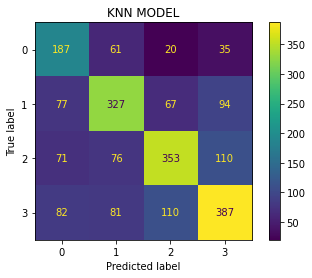

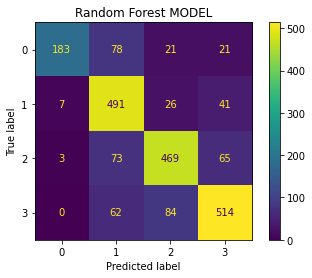


The KNN accuracy is: 0.5865294667913938
The RF accuracy is: 0.775023386342376

The KNN F1 is: 0.5797801438082046
The RF F1 is: 0.7692772297820207

The used features are: 
          Left-0     Left-1     Left-2     Left-3     Left-4     Left-5  \
0      91.034258  89.989285  89.446541  90.484821  90.426471  90.335952   
1      89.189282  90.032590  90.520370  90.535173  89.393462  89.260975   
2      89.405825  90.062178  89.889318  90.441738  90.071239  89.969749   
3      89.058885  89.907091  89.644695  89.760700  89.699774  89.692021   
4      89.923877  90.984776  90.424379  90.550879  90.366908  90.284532   
...          ...        ...        ...        ...        ...        ...   
10685  93.249352  93.249352  93.249352  93.249352  93.249352  93.249352   
10686  93.249352  93.249352  93.249352  93.249352  93.249352  93.249352   
10687  93.249352  93.249352  93.249352  93.249352  93.249352  93.249352   
10688  93.249352  93.249352  93.249352  93.249352  93.249352  93.249352   
106

,Left-0,Left-1,Left-2,Left-3,Left-4,Left-5,Left-6,Left-7,Left-8,Left-9,...,Right-296,Right-297,Right-298,Right-299,Averaged Diameter,Difference Diameter,isBlink-Left,isBlink-Right,Luminance,Labels
0,91.034258,89.989285,89.446541,90.484821,90.426471,90.335952,90.534715,90.501256,90.304912,90.299277,...,96.009051,95.905279,95.864096,95.688545,46.345515,-2.967561,0.181667,0.204167,1,0
1,89.189282,90.032590,90.520370,90.535173,89.393462,89.260975,89.723475,89.739829,89.843400,89.386548,...,94.910011,94.796925,94.770575,94.540734,46.310302,-2.970814,0.230000,0.254167,1,0
2,89.405825,90.062178,89.889318,90.441738,90.071239,89.969749,89.973210,89.938218,89.923749,89.902937,...,93.862190,94.332346,93.669062,92.983115,46.262647,-2.944221,0.230000,0.282500,1,0
3,89.058885,89.907091,89.644695,89.760700,89.699774,89.692021,89.670517,89.651260,89.632876,89.609174,...,93.192351,93.481313,92.260677,92.124016,46.196961,-2.897179,0.195833,0.249167,1,0
4,89.923877,90.984776,90.424379,90.550879,90.366908,90.284532,90.175600,90.071465,89.966849,89.862239,...,92.122490,92.648193,92.582692,92.805996,46.140701,-2.861161,0.151667,0.199167,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10685,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,90.071891,90.003222,89.971891,89.788091,46.141200,0.966951,1.000000,0.642500,1,3
10686,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,90.128886,90.044882,89.943202,89.981152,46.121692,1.005967,1.000000,0.592500,1,3
10687,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,89.972416,90.028453,90.053404,89.925440,46.103429,1.042494,1.000000,0.572500,1,3
10688,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,93.249352,...,89.687432,89.648607,89.688793,89.499107,46.075288,1.098775,1.000000,0.598333,1,3


In [13]:
# The pipeline for experiments.

# Get validated instances.
df_all_features = validate_instances(df_input=df_numeric_features)

# Looping and fine-tuning hyper-parameters. <TODO>

# Compare different features.
# Time-domain baseline feature sets.
time_domain_features = [AVE_DM, DIFF_DM]
df_baseline_time_features = select_features(df_input=df_all_features, selected_feature_sets=time_domain_features, dropped_feature_sets=False)
train_test_models(df_input=df_baseline_time_features, label_string='Time-domain-based Features')

# # Freqeuncy baseline feature sets.
# freq_domain_ipa_features = [IPA_LEFT, IPA_RIGHT]
# df_baseline_freq_features_ipa = select_features(df_input=df_all_features, selected_feature_sets=freq_domain_ipa_features, dropped_feature_sets=False)
# train_test_models(df_input=df_baseline_freq_features_ipa, label_string='Freq-domain-based IPA Features')

# freq_domain_lhipa_features = [LHIPA_LEFT, LHIPA_RIGHT]
# df_baseline_freq_features_lhipa = select_features(df_input=df_all_features, selected_feature_sets=freq_domain_lhipa_features, dropped_feature_sets=False)
# train_test_models(df_input=df_baseline_freq_features_lhipa, label_string='Freq-domain-based LHIPA Features')

# # Only wavelet coefficients features.
# dropped_IPA_LHIPA_AVE_DIFF = [AVE_DM, DIFF_DM, IPA_LEFT, IPA_RIGHT, LHIPA_LEFT, LHIPA_RIGHT]
# df_only_coefs = select_features(df_input=df_all_features, selected_feature_sets=False, dropped_feature_sets=dropped_IPA_LHIPA_AVE_DIFF)
# train_test_models(df_input=df_only_coefs, label_string='Only Wavelet Coefficients Features')

# IPA LHIPA and AVE_DM + DF_DM features.
freq_time_baseline_features = [AVE_DM, DIFF_DM, IPA_LEFT, IPA_RIGHT, LHIPA_LEFT, LHIPA_RIGHT]
df_baselines = select_features(df_input=df_all_features, selected_feature_sets=freq_time_baseline_features, dropped_feature_sets=False)
train_test_models(df_input=df_baselines, label_string='All Time and Frequency Domain Baseline Features')

# My proposed feature based features.
dropped_IPA_LHIPA_features = [IPA_LEFT, IPA_RIGHT, LHIPA_LEFT, LHIPA_RIGHT]
df_proposed = select_features(df_input=df_all_features, selected_feature_sets=False, dropped_feature_sets=dropped_IPA_LHIPA_features)
train_test_models(df_input=df_proposed, label_string='My Proposed Features')

# # All features baseline.
# df_all_baseline = select_features(df_input=df_all_features, selected_feature_sets=False, dropped_feature_sets=False)
# train_test_models(df_input=df_all_baseline, label_string='All Features')

## TODO list

In [14]:
# <TODO: get an arguments stuff>
# def parse_args():
#     parser = argparse.ArgumentParser()
#     parser.add_argument("--path", type=str, default='/content/gdrive/MyDrive/CS5242/project', 
#                         help="path")
#     parser.add_argument('--using_cuda', type=bool, default=True,
#                         help='cuda/cpu')
#     parser.add_argument('--gpu_ids', type=bool, default=[0],
#                         help='cuda/cpu')
#     parser.add_argument('--times', type=int, default=1,
#                         help='loop times of the whole process')
#     parser.add_argument('--sequence_len', type=int, default=1,
#                         help='20/1')
#     parser.add_argument('--train', type=bool, default=True,
#                         help='')
#     parser.add_argument('--predict', type=bool, default=True,
#                         help='')
#     parser.add_argument('--debug_mode', type=bool, default=False,
#                         help='adjust parameters ?')
#     # parser.add_argument('--model', type=str, default='bert',
#     #                     help='support bert/bert_lstm/bert_cnn/word2vec')
#     parser.add_argument('--model', type=str, default='MLP', choices=['bert', 'bert_lstm', 'bert_cnn', 'word2vec', 'MLP'], help='support bert/bert_lstm/bert_cnn/word2vec/MLP')
    
#     parser.add_argument('--language', type=str, default='en',
#                         help='support en')
#     parser.add_argument('--early_stop', type=int, default=60,
#                         help='')
#     parser.add_argument('--features_dim', type=int, default=768,# ?
#                         help='')
#     parser.add_argument('--batch_size', type=int, default=16,
#                         help='')
#     parser.add_argument('--train_rate', type=float, default=0.6,
#                         help='')
#     parser.add_argument('--test_rate', type=float, default=0.2,
#                         help='')
#     parser.add_argument('--num_workers', type=int, default=0,
#                         help='num workers of loading data')
    
#     parser.add_argument('--label', type=str, default='activation',
#                         help='support activation/polarity')
#     parser.add_argument('--num_classes', type=int, default=3,
#                         help='class number')
    
#     parser.add_argument('--train_size', type=str, default='normal',
#                         help='normal')
#     parser.add_argument('--model_save_path', type=str, default='model_save',
#                         help='path to save model.')
#     parser.add_argument('--data_dir', type=str, default='/word2vec.pkl',
#                         help='path to data directory word2vec.pkl/bert_feature.pkl')
#     parser.add_argument('--log_path', type=str, default='/content/gdrive/MyDrive/CS5242/project/log/',
#                     help='path to data directory feature.pkl')
#     return parser.parse_args(args = [])
#
#     args = parse_args()
# def parse_args():
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--max_seq_length', type=int, default = 50,
#                         help='length')
#     parser.add_argument('-f')
#     return parser.parse_args()
# 
#     save_data(args, features, '/word2vec.pkl')
# def save_data(args, features, save_path):
#     path = os.path.abspath(os.path.join(os.getcwd(), ".."))
#     with open(os.path.join(path, "data/" + save_path),'wb') as file_obj:
#         pickle.dump(features,file_obj)
#         print('Save Successful!')